In [1]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import fft, arange, fftpack

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames, split_on_classes, create_row_mask
from preprocessing.process_data import get_data

from utils.plot_utils import plot_spectra_1axis, plot_spectra_3axis
from utils.plot_utils import plot_3axis_raw_signal_1, plot_3axis_raw_signal_compare
from utils.plot_utils import single_file_plots, load_file_to_pandas


%matplotlib inline 

### Experimental setup
* **9** children, 5 with motor derailments, 4 normal motor skills
* game device: futuro cube // game: roadrunner with 3 levels of difficulty 
* a game is 120 seconds long, level increases after 40 seconds
* sampling rate accelerometer data round 20 Hz

### Labeling of children
e.g. ID6:0:Age8:0:1 contains five labels
* ID6 = child is identified by id 6
* 0 = normal, 1 = derailed motor skills
* Age8 = child of age 8
* 0 = female, 1 = male
* 0 = left handed, 1 = right handed


### Plot 1 - Raw compared to filtered signal (time domain)

#### Note:
* Raw time signal in blue
* filtered signal in red
* Applied two Butterworth filters of order 5 (based on first analysis)
* low-pass filter with 2Hz cutoff frequency
* high-pass filter with 0.5Hz cutoff frequency

Each plot shows the raw (blue) and filtered (red) signal for one child, separated for the 3-axis accelerometer


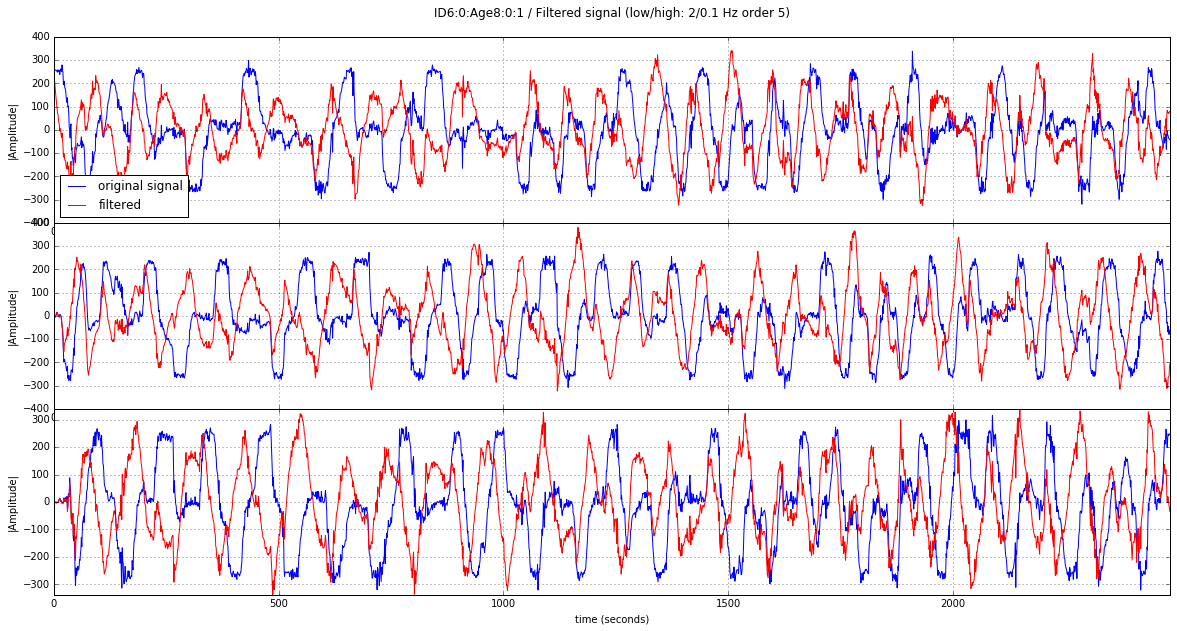

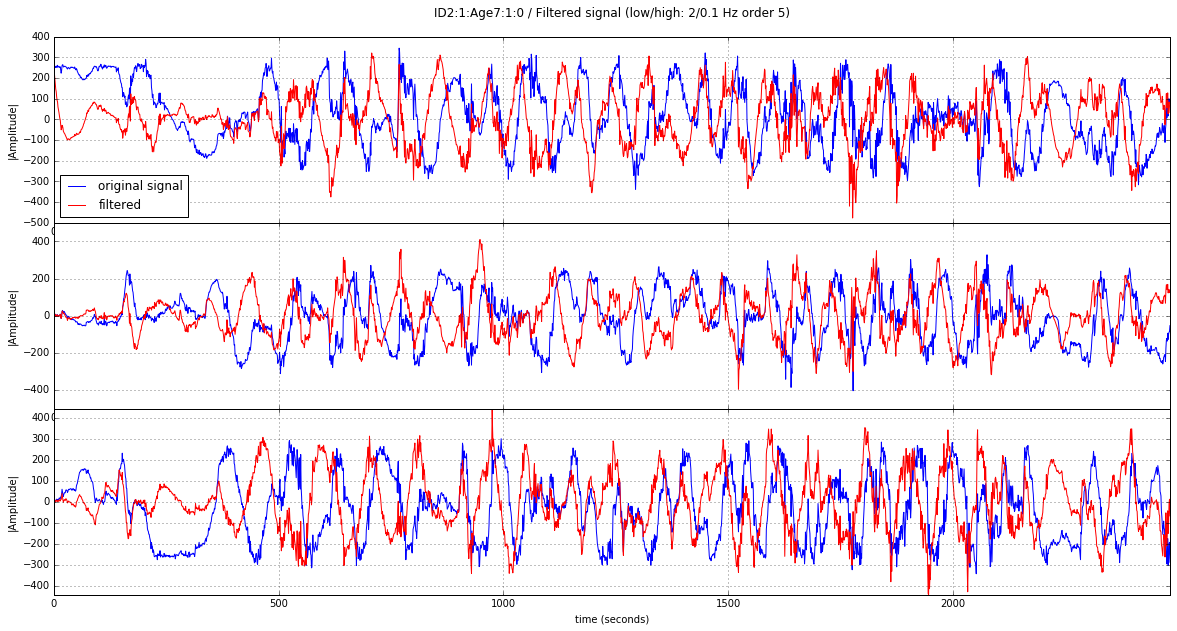

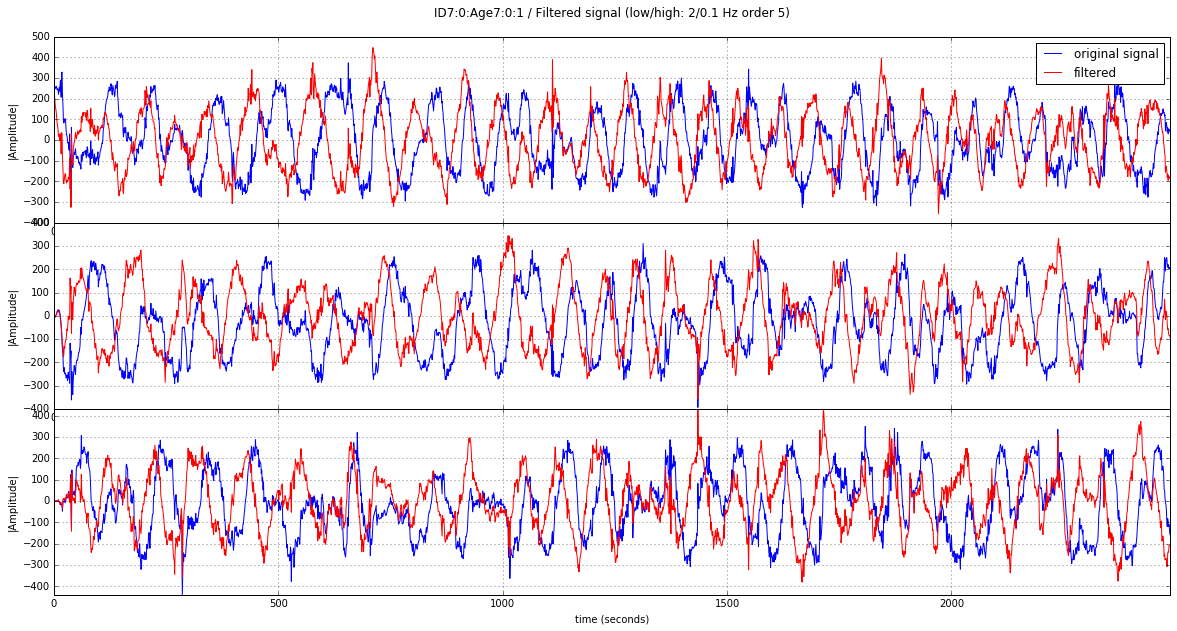

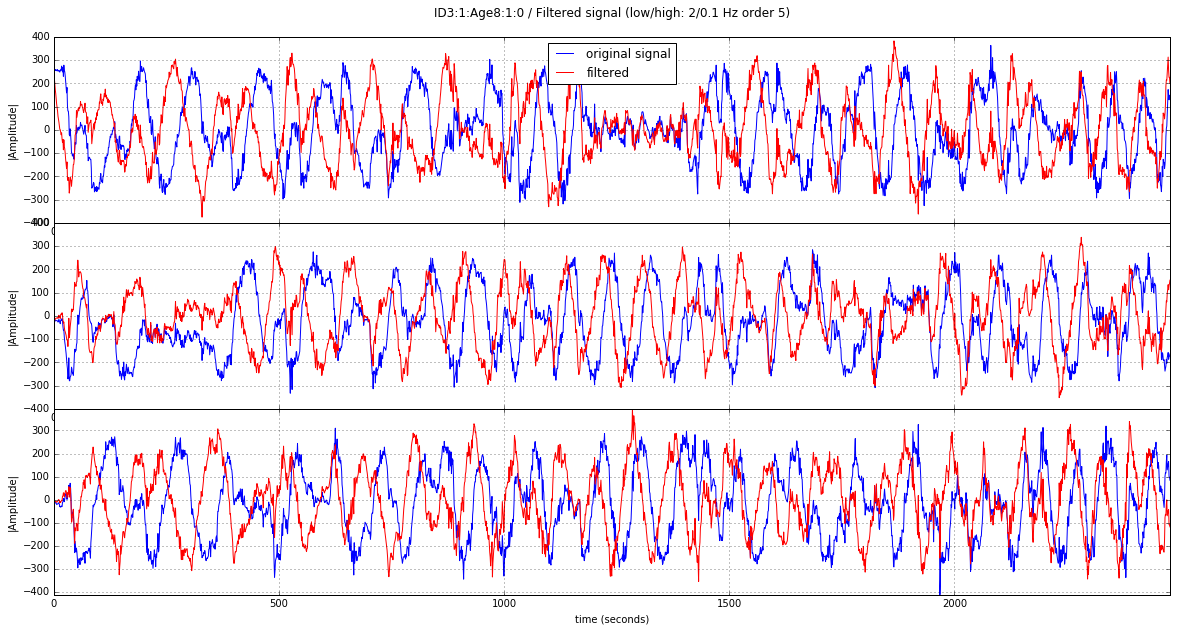

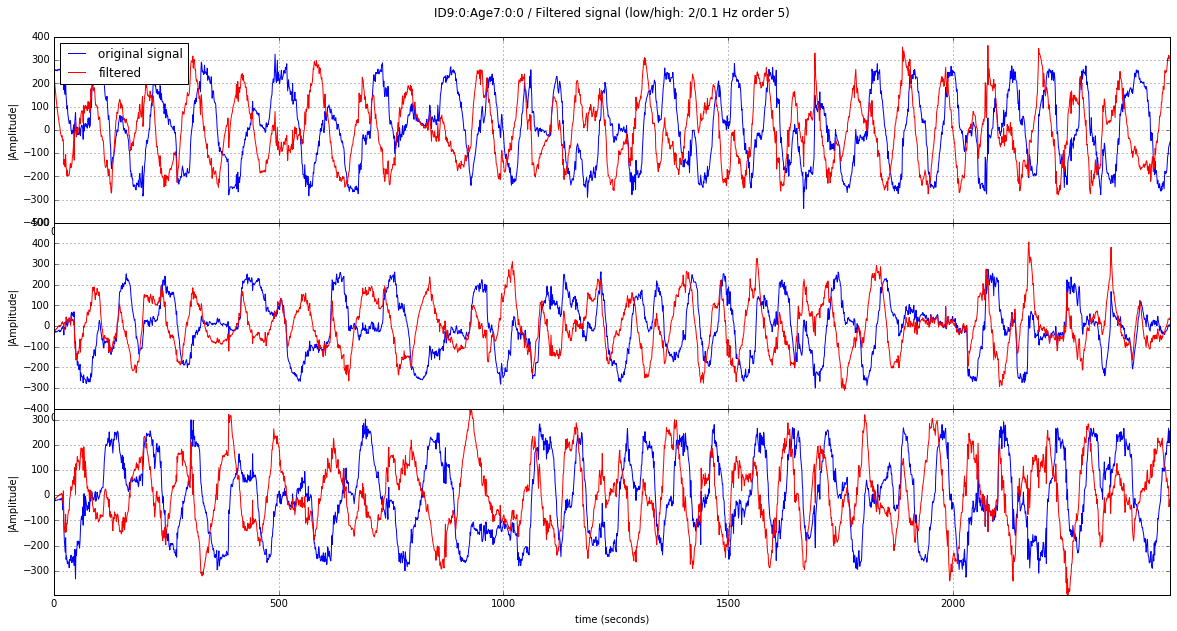

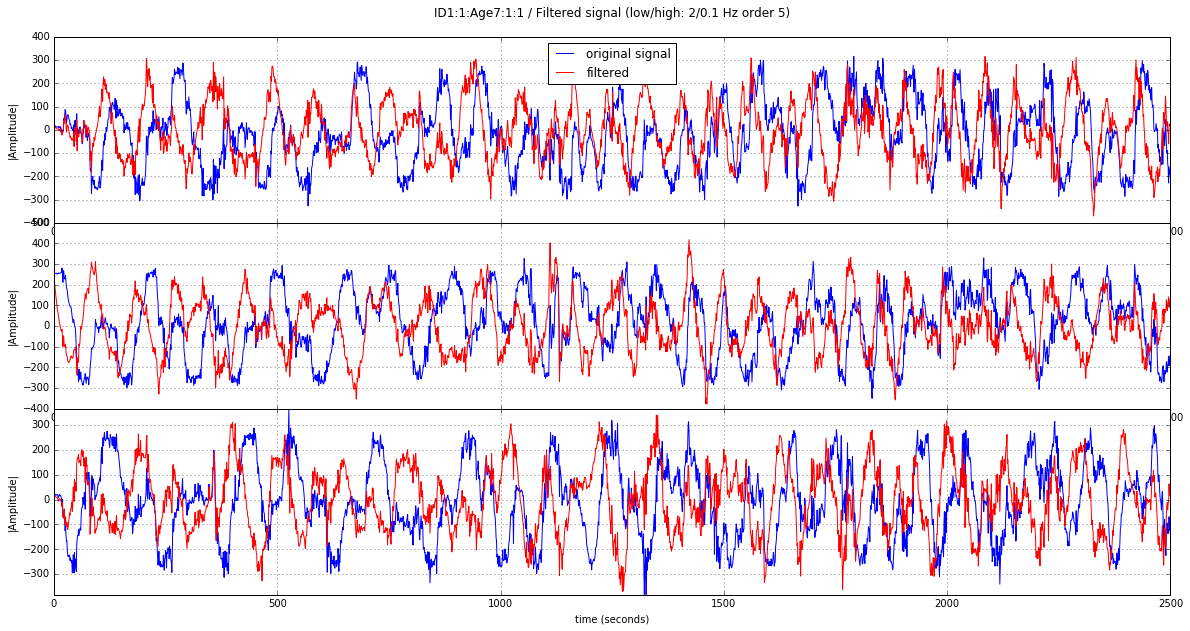

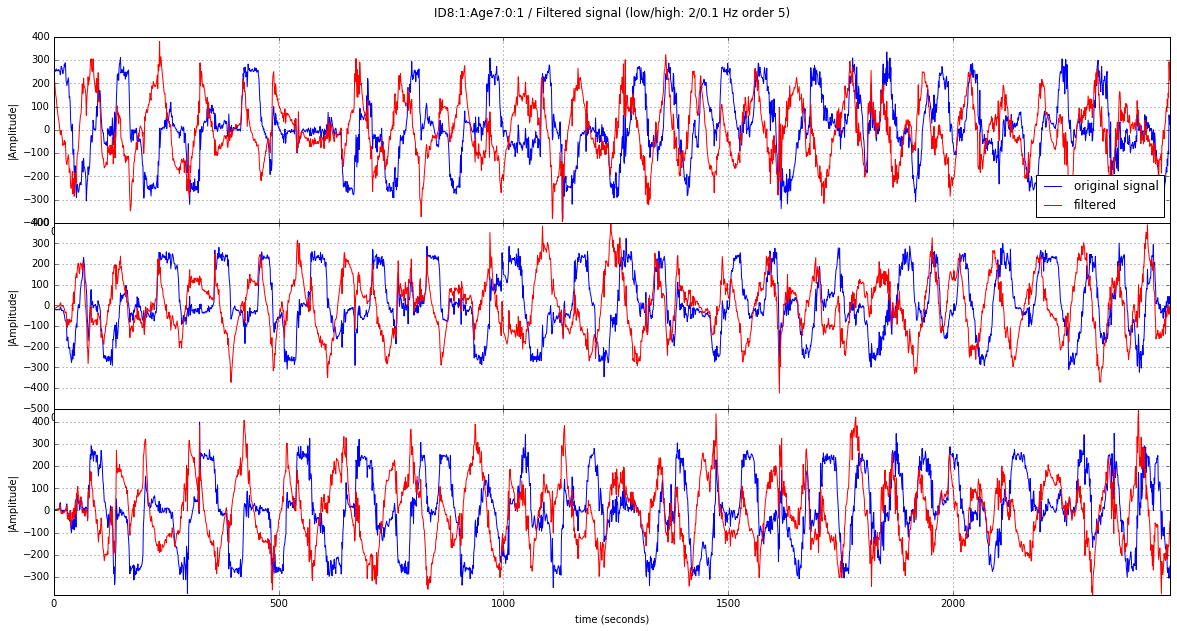

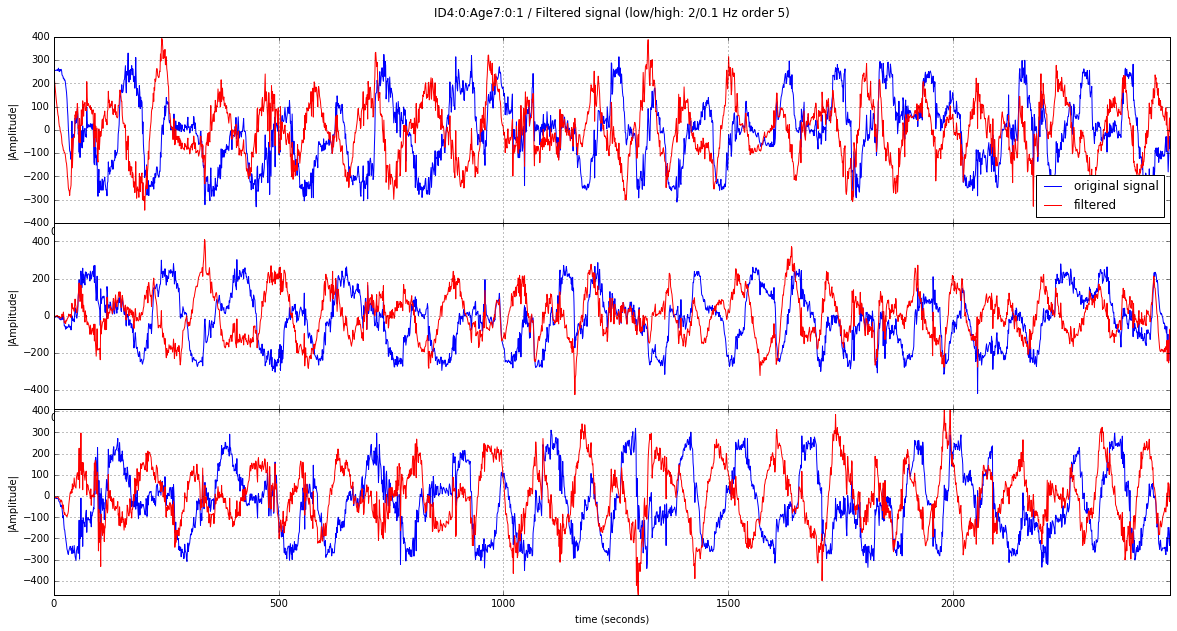

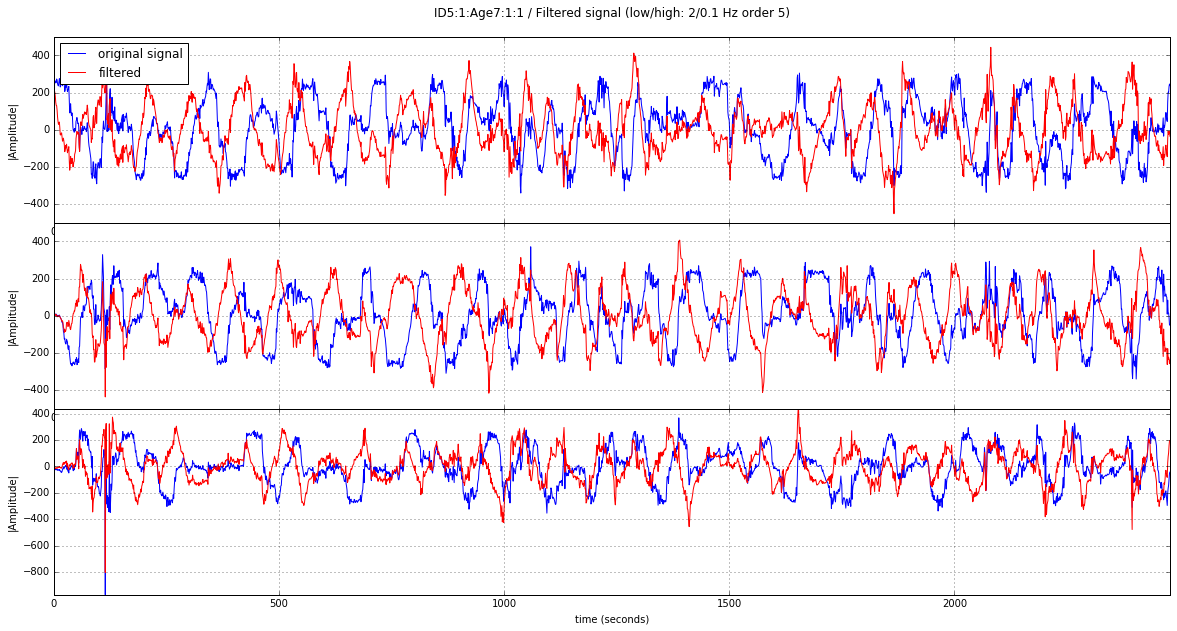

In [2]:
files = get_array_filenames('20160921', device='futurocube', game='roadrunner', sequence=1, file_ext='csv')
freq = 20   # Hz

for filename in files:
    labels = filename[filename.index('[') + 1:filename.index(']')]
    
    r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()

    single_file_plots(r_signal, freq, lowcut=2, highcut=0.1, f_type='lowhigh', b_order=5, 
                      plot_type=1, width=20, height=10, p_legend=True,
                      add_to_title=labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=True, use_mag=False, plot_sig=[1,2])

### Plot 2/3/4/5 - Effect of filtering and window function on signal in frequency domain

##### Note, for each child (9 in total) four plots will be shown in the following order:

####  Plot 2 - Raw signal in frequency domain

#### Plot 3 - Effect of Butterworth filter 

     Note: 
        * applied two Butterworth filters of order 5 (based on first analysis)
        * low-pass filter with 2Hz cutoff frequency
        * high-pass filter with 0.1 Hz cutoff frequency
    
    
#### Plot 4 - Effect of Butterworth filter & Hamming window 

     Note:
        * applied two Butterworth filters of order 5 (based on first analysis)
        * low-pass filter with 2Hz cutoff frequency
        * high-pass filter with 0.1 Hz cutoff frequency

        * applied ** Hamming window ** to (filtered) signal for frequency leakage prevention


#### Plot 5 - Effect of Butterworth filter & Hamming window - magnitude signal in frequency domain

    Note, instead of the 3-axis acceleromter signal these plots show the magnitude signal (one axis)
        * apply Butterworth filter to 3-axis signal
        * calculate magnitude signal
        * apply Hamming window

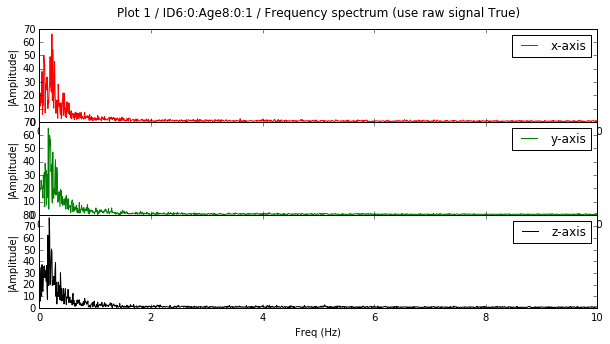

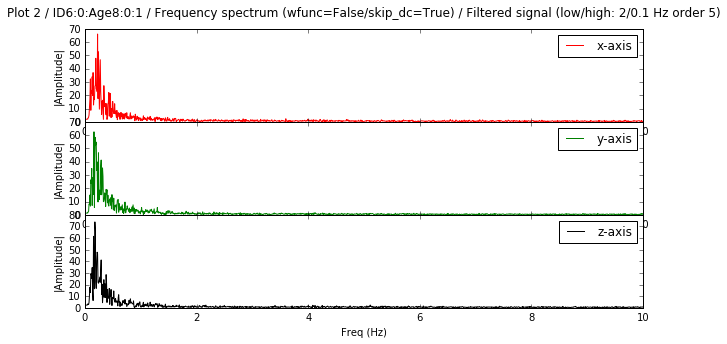

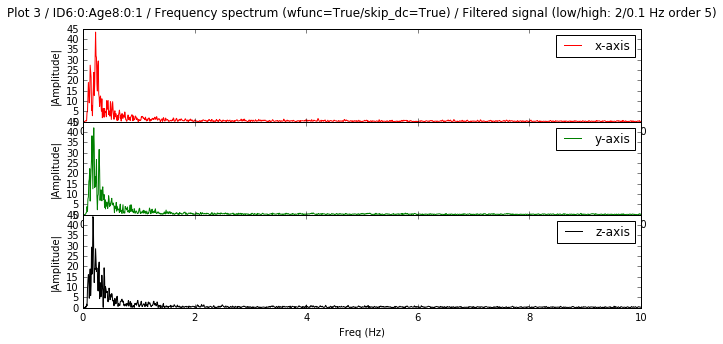

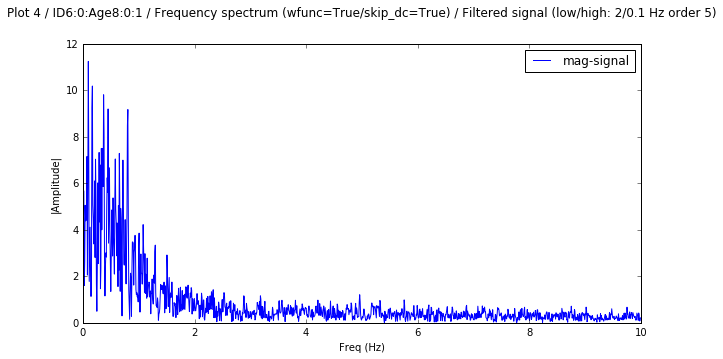

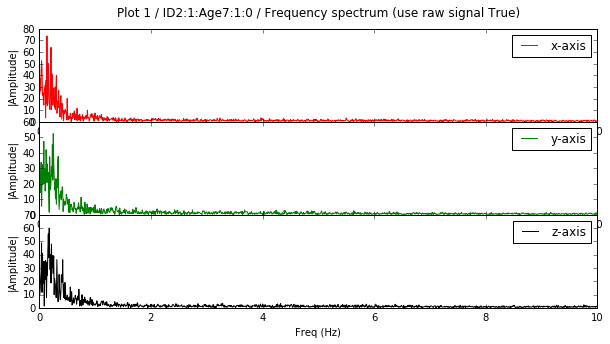

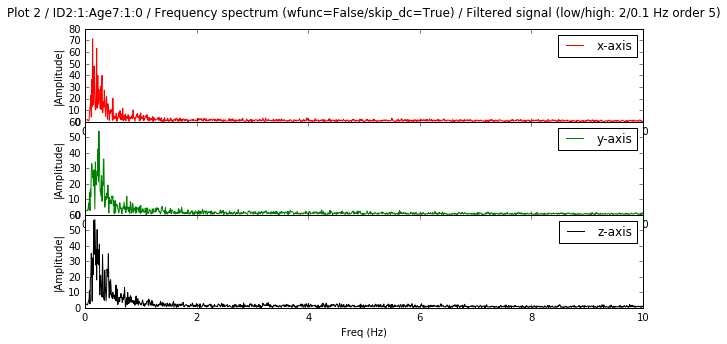

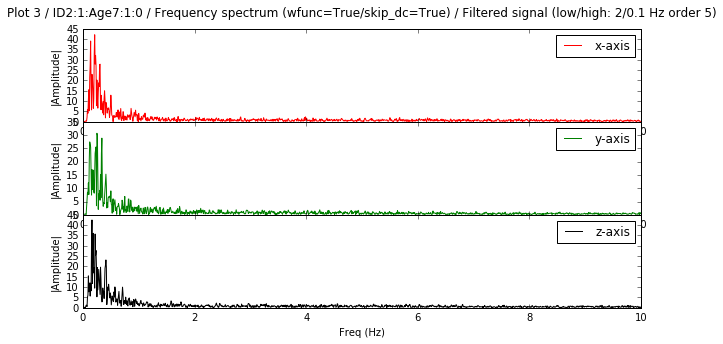

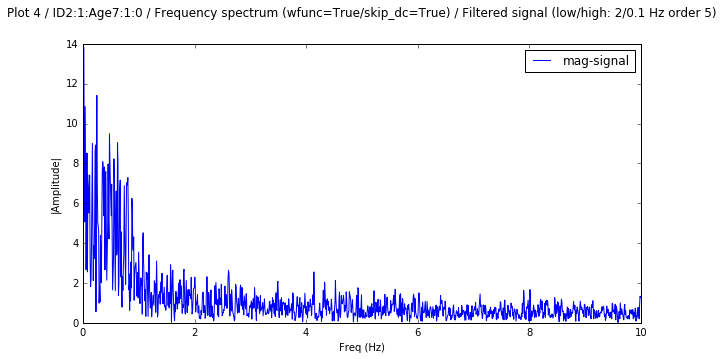

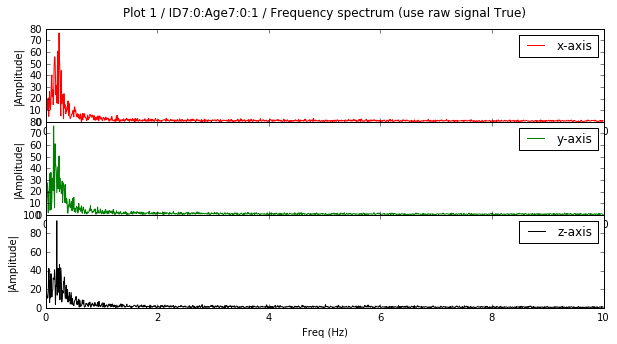

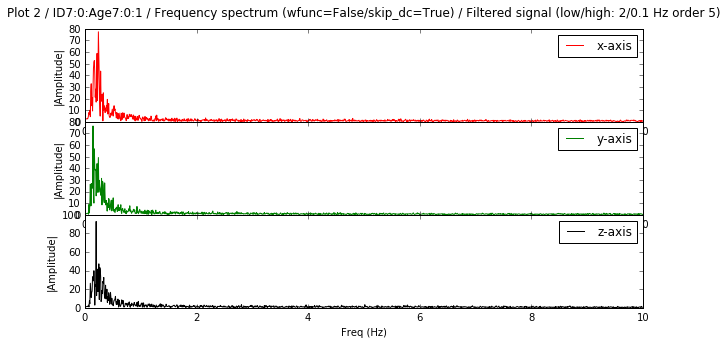

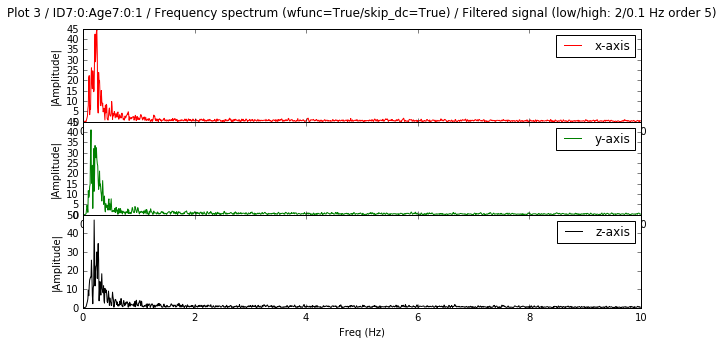

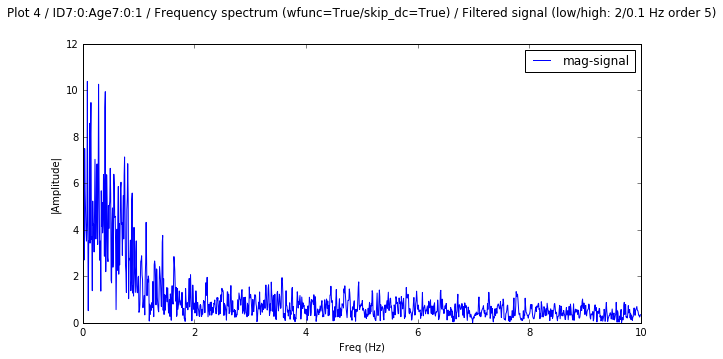

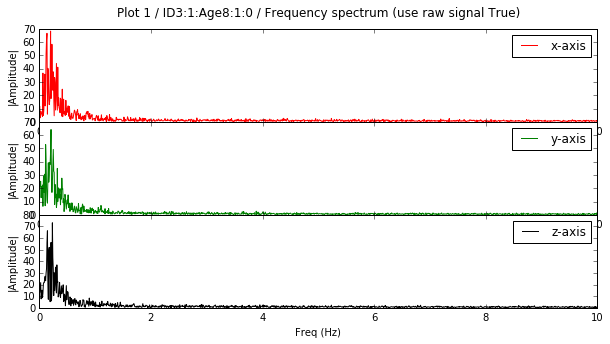

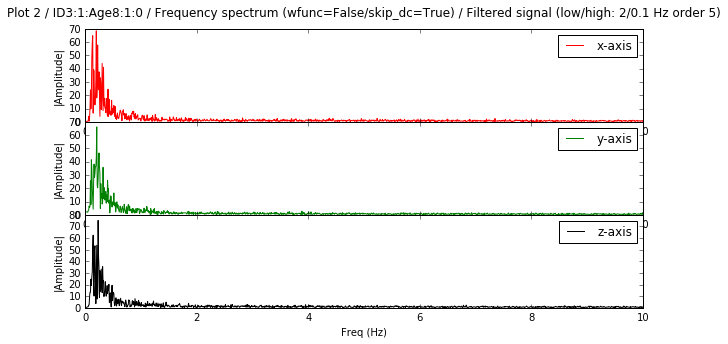

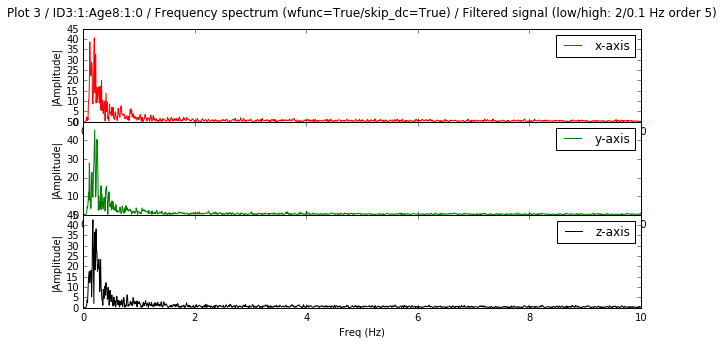

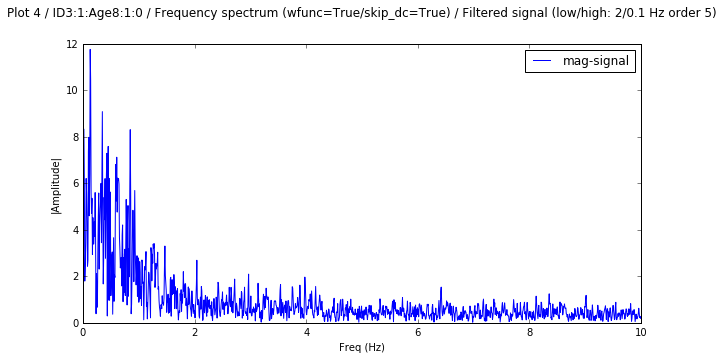

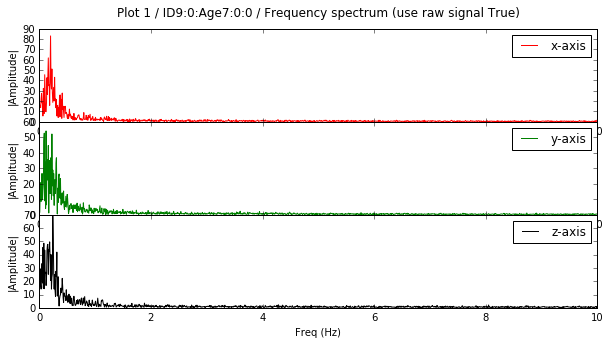

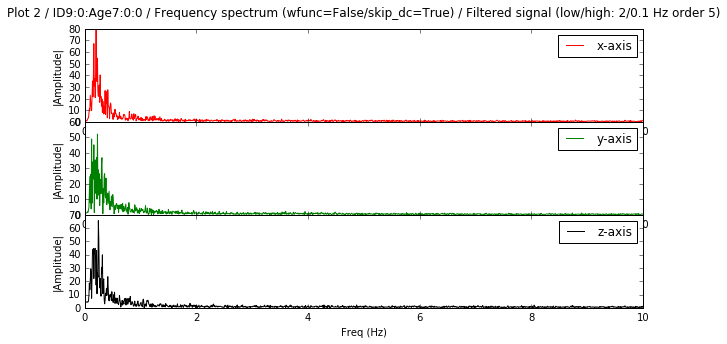

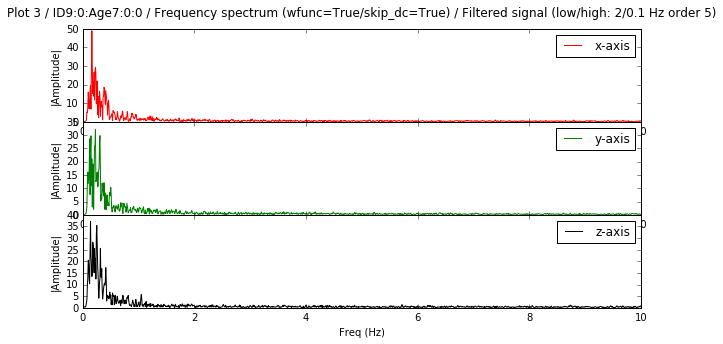

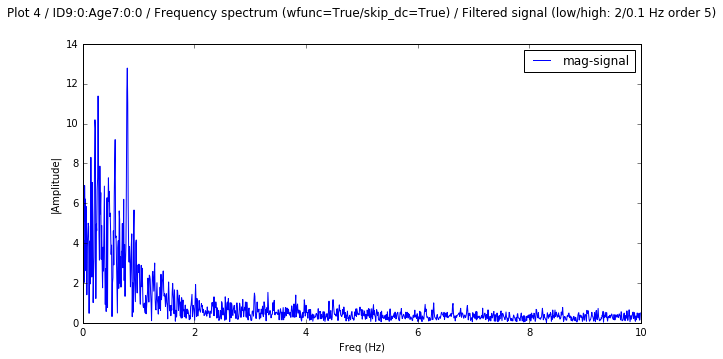

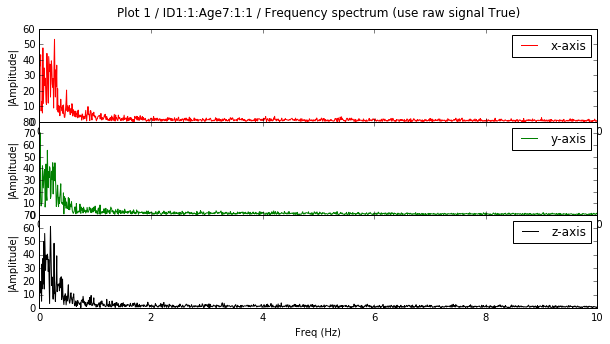

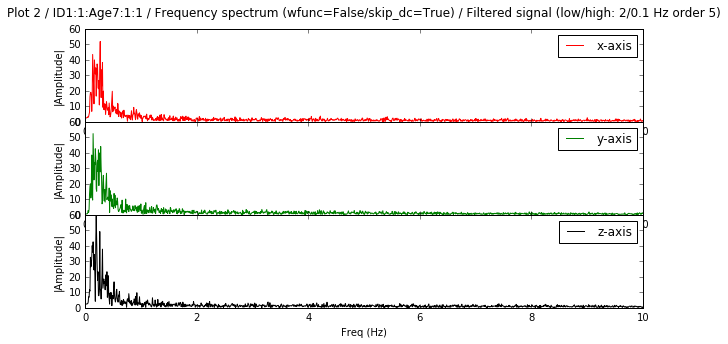

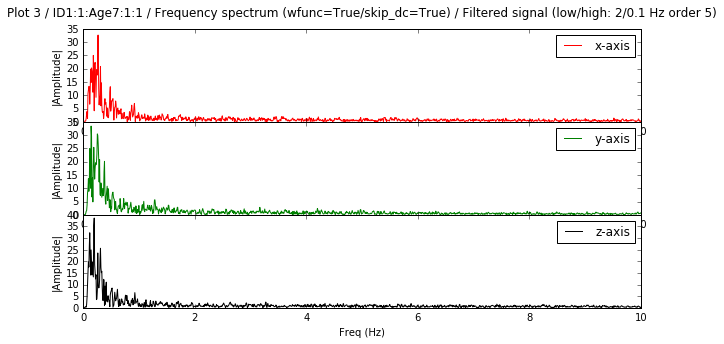

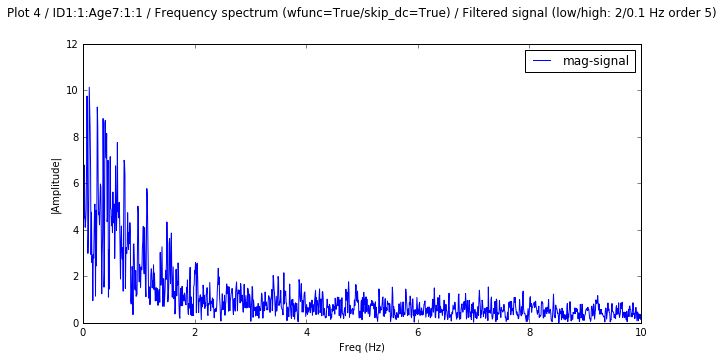

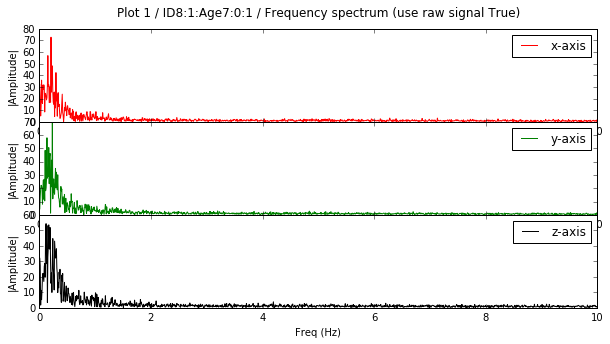

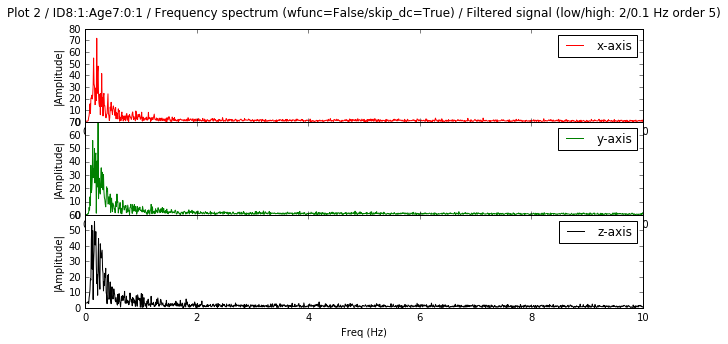

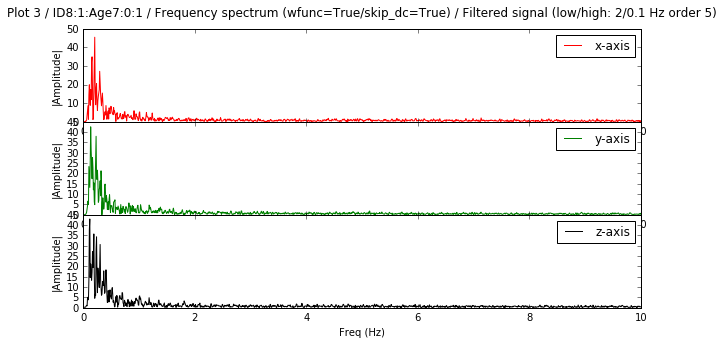

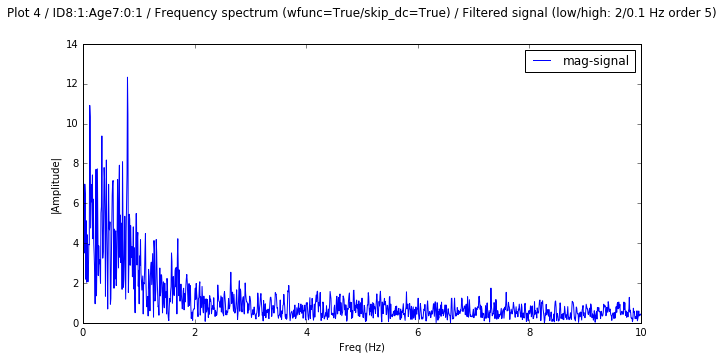

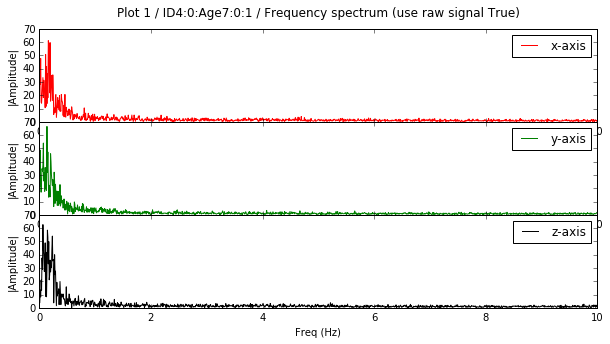

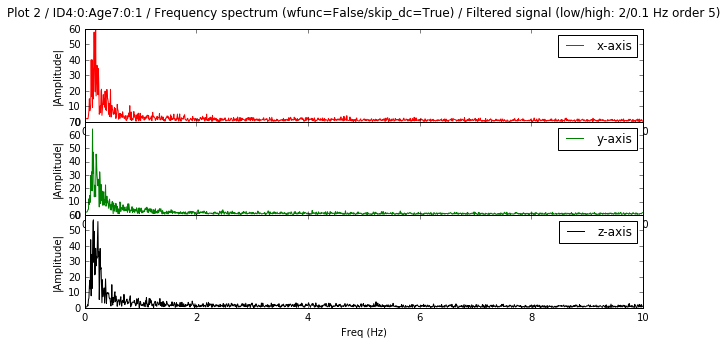

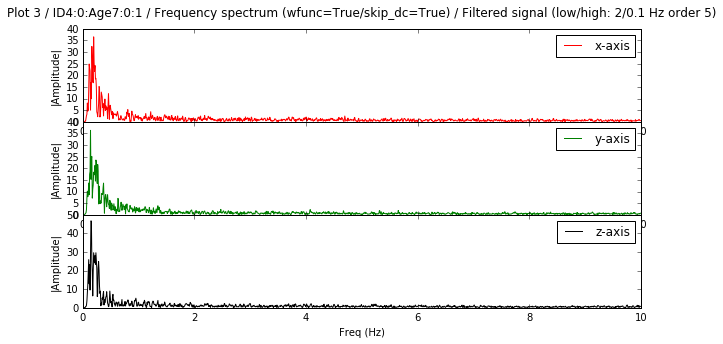

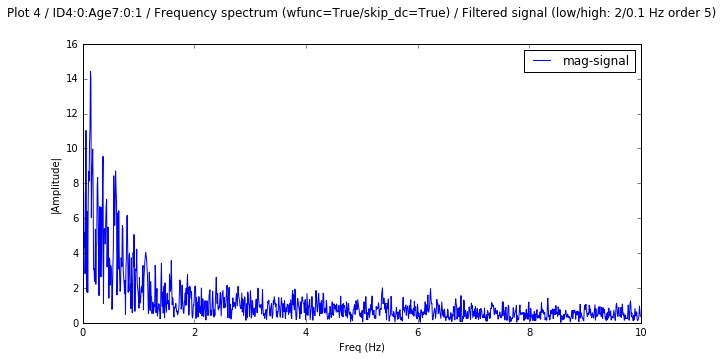

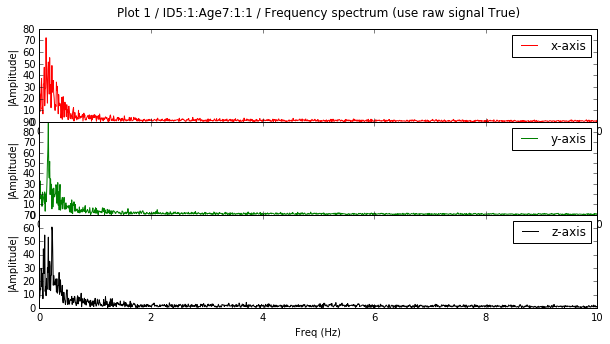

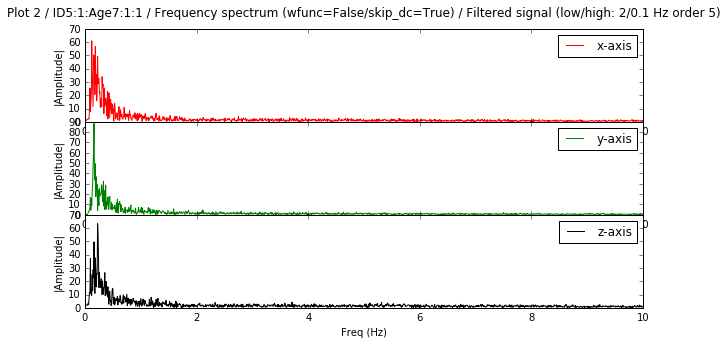

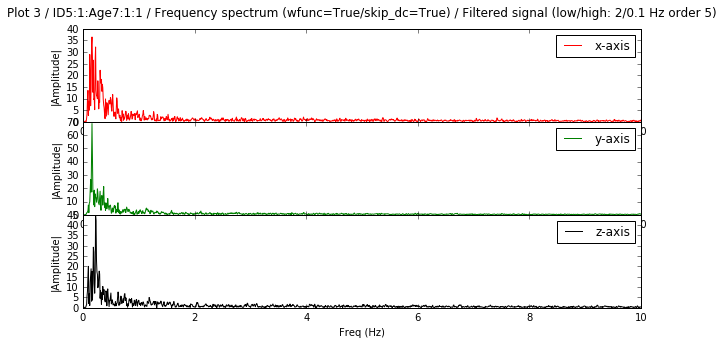

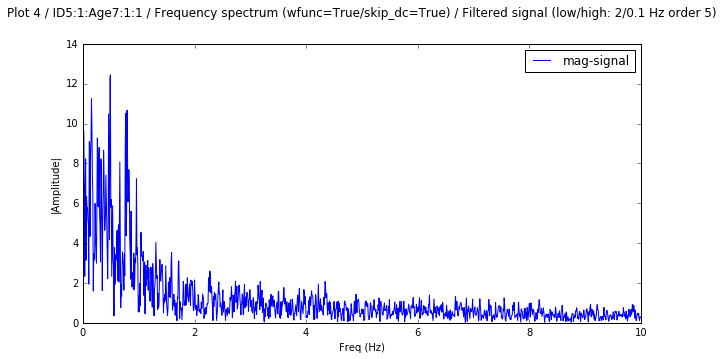

In [8]:
files = get_array_filenames('20160921', device='futurocube', game='roadrunner', sequence=1, file_ext='csv')
freq = 20   # 20 Hz
t_cufoff = 0*freq
exp_labels = []

for filename in files:
    labels = filename[filename.index('[') + 1:filename.index(']')] # .split(':')
    
    r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()

    single_file_plots(r_signal, freq, 
                      plot_type=3, width=10, height=5, p_legend=True,
                      add_to_title="Plot 2 / " + labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=True, use_mag=False)
    
    single_file_plots(r_signal, freq, lowcut=2, highcut=0.1, f_type='lowhigh', b_order=5, 
                      plot_type=3, width=10, height=5, p_legend=True,
                      add_to_title="Plot 3 / " + labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=False, use_mag=True)
    
    single_file_plots(r_signal, freq, lowcut=2, highcut=0.1, f_type='lowhigh', b_order=5, 
                      plot_type=3, width=10, height=5, p_legend=True,
                      add_to_title="Plot 4 / " + labels + " / ",
                      apply_w_func=True, skip_dc=True, use_raw_sig=False, use_mag=True)
    
    single_file_plots(r_signal, freq, lowcut=2, highcut=0.1, f_type='lowhigh', b_order=5, 
                      plot_type=2, width=10, height=5, p_legend=True,
                      add_to_title="Plot 5 / " + labels + " / ",
                      apply_w_func=True, skip_dc=True, use_raw_sig=False, use_mag=True)
    
    


In [9]:
train_data_f, train_labels_f, dta_dict_f = get_data('20160921', force=False, apply_window_func=True, calc_mag=True,
                                              extra_label="20hz_1axis_f2.01.5_10f_45_10_1", optimal_w_size=False,
                                                   f_type='lowhigh', lowcut=2, highcut=0.1, b_order=5)

# for cross validation train data has to have 2 dim tensor
train_data_f_r = np.reshape(train_data_f, (train_data_f.shape[0], train_data_f.shape[1] * train_data_f.shape[2]))
# for cross validation train labels has to have 1 dim tensor
train_labels_f_r = np.reshape(train_labels_f, (train_data_f.shape[0]))
print(train_data_f_r.shape)
print(train_labels_f_r.shape)
print(dta_dict_f["features"])
print(dta_dict_f["filter"])
print(dta_dict_f["filter_specs"])
print(dta_dict_f["window_func"])
num_of_features = len(dta_dict_f["features"])
num_of_windows = dta_dict_f["num_of_windows"]
feature_list = dta_dict_f["features"]

multiplier = int(train_data_f_r.shape[0]/num_of_windows)
b_mask = create_row_mask([True, False, True, False, True], multiplier)
dta_train_subset = train_data_f[b_mask, :]
lbl_train_subset = train_labels_f_r[b_mask]

INFO - Used data label 20160921_futurocube_roadrunner_20hz_1axis_f2.01.5_10f_45_10_1
INFO Loading matrices from h5 file /home/jogi/git/repository/smart_play_set/data/futurocube/roadrunner/20160921_futurocube_roadrunner_20hz_1axis_f2.01.5_10f_45_10_1.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data'])
INFO - Loading data description from json.
(45, 10)
(45,)
[u'min', u'max', u'mean', u'std', u'median', u'rms', u'range', u'dc', u'energy', u'power_spec_entropy']
lowhigh
[2, 0.1, 5]
True


### Plot 6 - Feature values per game level/window for both motor skill classes

#### Note: 
* the following features were calculated in the time domain:
        min, max, mean, std, median, range, rms
* the following features were calculated in the frequency domain:
        DC, energy, power-spectrum-entropy
* the plots underneath show for each feature the values for both motor skill classes (for 9 children)
* the x-axis is labeled as "Window", in this case a window is equivalent to a game level (three levels) which lasted 40 seconds
* class 0 = normal motor skills, class 1 = derailed motor skills

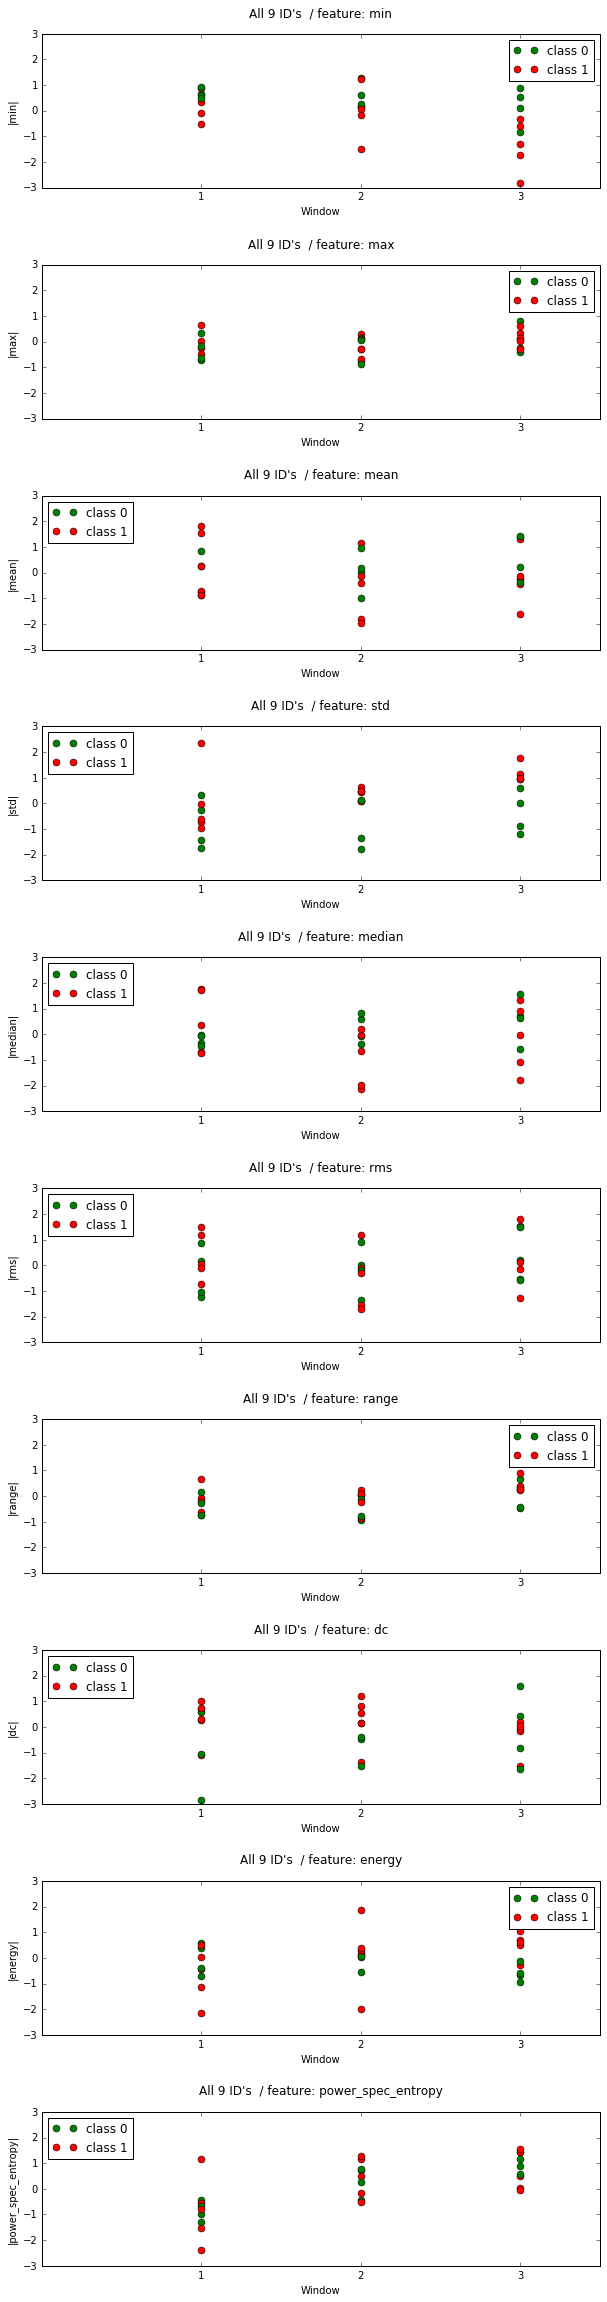

In [14]:
num_of_files = int(dta_dict_f["num_of_files"])
label_dicts = dta_dict_f["id_attributes"]


plot_one_feature_v2(dta_train_subset, num_of_windows-2, 9, label_dicts, features=feature_list, f_index=-1,  
                       p_legend=True, width=10, height=30)

### Plot 7 - Average feature values per game level/window for both motor skill classes

#### Note: 
* the following features were calculated in the time domain:
        min, max, mean, std, median, range, rms
* the following features were calculated in the frequency domain:
        DC, energy, power-spectrum-entropy
* the plots underneath show the **average** feature values per game level for both motor skill classes
* the x-axis is labeled as "Window", in this case a window is equivalent to a game level (three levels)
* the errorbars visualize the standard deviation
* class 0 = normal motor skills, class 1 = derailed motor skills

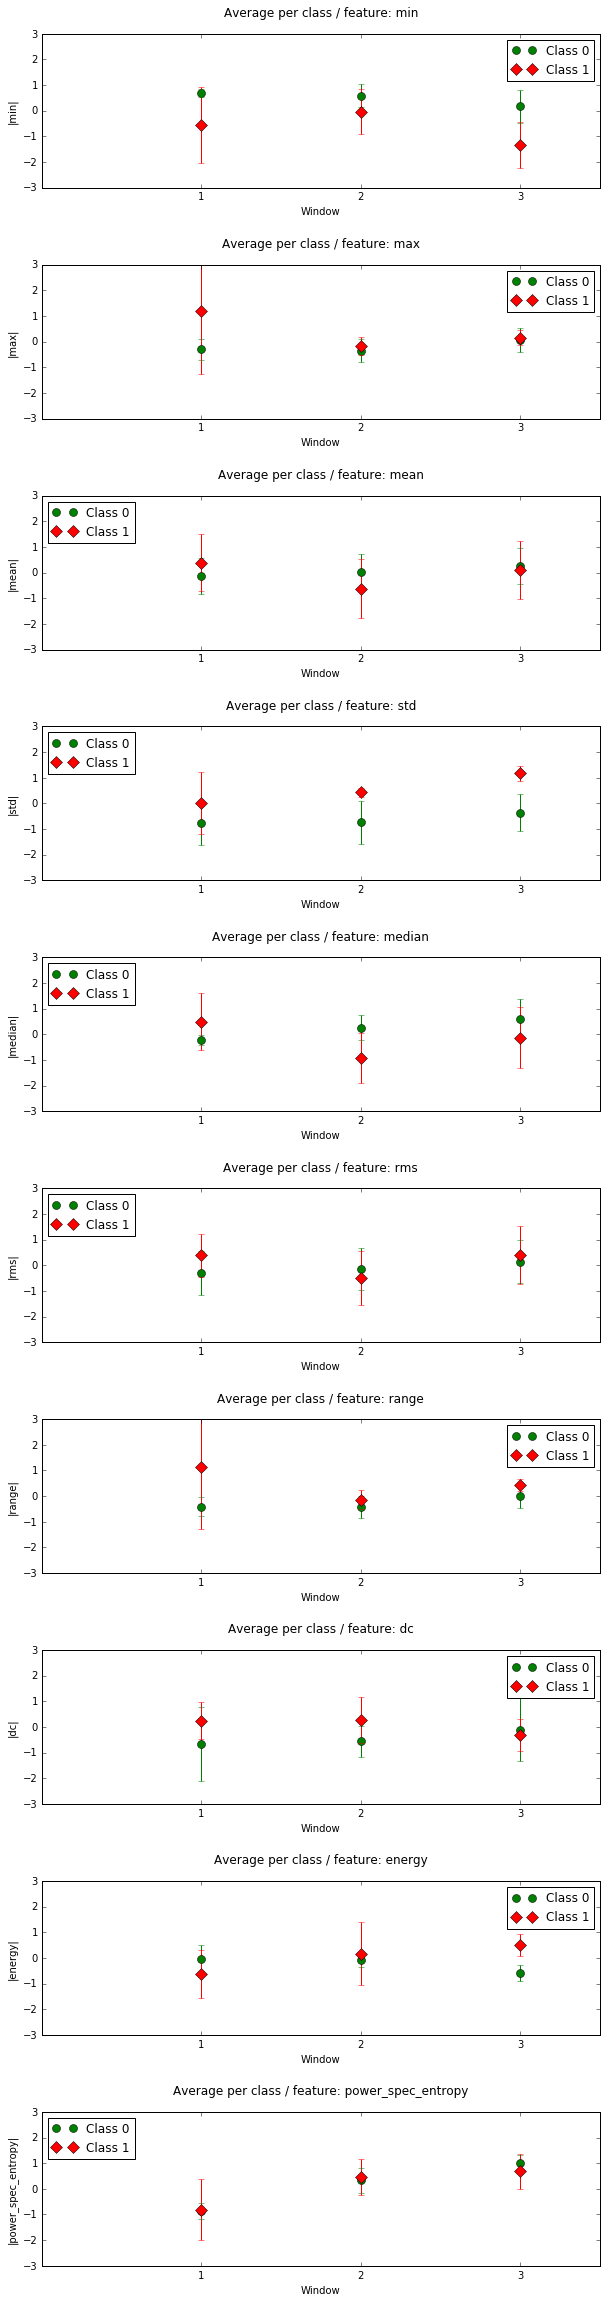

In [16]:
res = split_on_classes(dta_train_subset, np.reshape(lbl_train_subset, (lbl_train_subset.shape[0], 1)))
num_of_files = int(dta_dict_f["num_of_files"])
label_dicts = dta_dict_f["id_attributes"]

plot_one_feature_v3(res[0], res[1], num_of_windows-2, [0, 1], features=feature_list, f_index=-1,  
                       p_legend=True, width=10, height=5)

In [11]:
def plot_one_feature(data1, label1, f_index, features, data2=None, label2="", width=20, height=10, 
                           p_legend=False, xyz_axis=True):
    
    feature = features[f_index]
    data1 = np.reshape(data1[:, f_index, :], (data1.shape[0], data1.shape[2]))
    if data2 is not None:
        data2 = np.reshape(data2[:, f_index, :], (data2.shape[0], data2.shape[2]))
        p_title = label1 + " & " + label2 + " / feature: " + feature
    else:
        p_title = label1 + " / feature: " + feature
        
    t = np.arange(data1.shape[0])
    y_label = "|" + feature + "|"
    x_label = "|window|"
    
    plt.figure(figsize=(width, height))
    if xyz_axis:
        ax1 = plt.subplot(3, 1, 1)
    else:
        ax1 = plt.subplot(1, 1, 1)
        
    plt.title(p_title, y=1.08)

    plt.plot(t, data1[:, 0], label='x-axis ' + label1)
    if data2 is not None:
        plt.plot(t, data2[:, 0], label='x-axis ' + label2, color='r')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.ylabel(y_label)
    if p_legend:
        plt.legend(loc="best")
    
    if xyz_axis:
        plt.subplot(3, 1, 2, sharex=ax1)
        plt.plot(t, data1[:, 1], label='y-axis ' + label1)
        if data2 is not None:
            plt.plot(t, data2[:, 1], label='y-axis ' + label2, color='r')
        plt.xlabel(x_label)
        plt.grid(True)
        plt.ylabel(y_label)
        if p_legend:
            plt.legend(loc="best")

        plt.subplot(3, 1, 3, sharex=ax1)
        plt.plot(t, data1[:, 2], label='z-axis ' + label1)
        if data2 is not None:
            plt.plot(t, data2[:, 2], label='z-axis ' + label2, color='r')
        plt.xlabel(x_label)
        plt.grid(True)
        plt.ylabel(y_label)
        if p_legend:
            plt.legend(loc="best")

    plt.axis('tight')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()




In [ ]:
plot_one_feature(dta1, label1, data2=dta2, label2=label2, features=feature_list, f_index=6,  
                       p_legend=True, xyz_axis=True)

In [12]:
def plot_one_feature_v2(data, num_of_windows, n_files, l_dict, features, f_index=-1, width=20, height=10, 
                           p_legend=False):
    
    
    feature = features[f_index]
    t = np.arange(1, num_of_windows+1)
    x_label = "|window|"
    
    if f_index==-1:
        f_range = np.arange(len(features))
        if height < 40:
            height = 40
    else:
        f_range = [f_index]
        
    plt.figure(figsize=(width, height))
    plt.gca().set_autoscale_on(False)
    
    dta_0 = None
    dta_1 = None
    first_plot = True
        
    for i, f_idx in enumerate(f_range):
        feature = features[f_idx]
        y_label = "|" + feature + "|"
        ax1 = plt.subplot(len(f_range), 1, i+1)
        plt.ylabel(y_label)
        p_title = "All %d ID's " % n_files + " / feature: " +  feature
        plt.title(p_title, y=1.08)
        plt.xticks(t, t)
        plt.xlabel("Window")
    
        for idx in np.arange(n_files):
            offset = int(idx*num_of_windows)
            dta = np.reshape(data[offset:offset+num_of_windows, f_idx, :], (num_of_windows, data.shape[2]))

            label = "class %s" % l_dict[idx]["CLASS"]
            if l_dict[idx]["CLASS"] == '0':
                p_color = 'g'
                cls1, = plt.plot(t, dta[:, 0], color=p_color, marker='o', linestyle='None', markersize=7, 
                            label=label)
            else:
                p_color = 'r'
                cls2, = plt.plot(t, dta[:, 0], color=p_color, marker='o', linestyle='None', markersize=7,
                            label=label)
            
            plt.xlim([0, num_of_windows + 0.5])
            plt.ylim([-3,3])
        if p_legend and first_plot:
            ax1.legend(handles=[cls1, cls2], loc="best")
        else:
            first_plot = False

        # plt.axis('tight')
        plt.subplots_adjust(wspace=0, hspace=0.5)
    
    plt.show()

In [13]:
def plot_one_feature_v3(dta1, dta2, num_of_windows, labels, features, f_index=-1, width=20, height=10, 
                           p_legend=False):
    
    
    if f_index==-1:
        f_range = np.arange(len(features))
        if height < 40:
            height = 40
    else:
        f_range = [f_index]
        
    t = np.arange(1, num_of_windows+1)
    x_label = "|window|"
    
    plt.figure(figsize=(width, height))

    plt.gca().set_autoscale_on(False)
    plt.xlabel(x_label)
    label1 = "Class %d" % labels[0]
    label2 = "Class %d" % labels[1]
    dta1_dim1 = int(dta1.shape[0] / num_of_windows)
    dta2_dim1 = int(dta2.shape[0] / num_of_windows)
    first_plot = True
    
    for i, f_idx in enumerate(f_range):
        feature = features[f_idx]
        y_label = "|" + feature + "|"
        ax1 = plt.subplot(len(f_range), 1, i+1)
        plt.ylabel(y_label)
        p_title = "Average per class" + " / feature: " + feature   
        plt.title(p_title, y=1.08)
        plt.xticks(t, t)
        plt.xlabel("Window")
        for idx in np.arange(num_of_windows):

            dta1_m = np.reshape(dta1[idx::num_of_windows, f_idx, :], (dta1_dim1, dta1.shape[2]))
            dta2_m = np.reshape(dta2[idx::num_of_windows, f_idx, :], (dta2_dim1, dta2.shape[2]))  
            dta1_err = dta1_m.std(axis=0)
            dta2_err = dta2_m.std(axis=0)
            dta1_m = dta1_m.mean(axis=0)
            dta2_m = dta2_m.mean(axis=0)

            cls1, = plt.plot(t[idx], dta1_m, color='g', marker='o', linestyle='None', markersize=8, label=label1)
            plt.errorbar(t[idx], dta1_m, yerr=dta1_err, fmt='g')
            cls2, = plt.plot(t[idx], dta2_m, color='r', marker='D', linestyle='None', 
                                 markersize=8, label=label2)
            plt.errorbar(t[idx], dta2_m, yerr=dta2_err, fmt='r')
        
            plt.xlim([0, num_of_windows + 0.5])
            plt.ylim([-3,3])
        
        if p_legend:
            plt.legend(handles=[cls1, cls2], loc="best")

    
    # plt.axis('tight')
    plt.subplots_adjust(wspace=0, hspace=0.5)
    plt.show()